Stages of this analysis, in order to draw appropriate conclusions
Do this across multiple sessions
1. With regular PCA, we can see how multiple regions contribute (can correlate functional connectivity)
2. By separating out in time (50-60 bins and 60-70 in bins) we can see which modes are most active in each

        2a. Predict that ~sensory regions contribute early and ~memory/dm regions contribute later
3. With sparse PCA, we can see how individual regions contribute, also in each time bin
4. Cluster activity in regular and sparse to see whether slow/fast and small margin/large margin separate
5. Using decision tree, on regular and sparse in turn, try to predict slow/fast response, small/large margin, left/right (as control), and correct/incorrect
6. Take outcomes from 4 and 5 to refer back to the PC contributions from each area to draw conclusions

In [1]:
#@title Data loading and imports
import numpy as np
from sklearn.decomposition import PCA, SparsePCA
import matplotlib.pyplot as plt
from copy import deepcopy as cdc
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score

#import helper functions
from utils import *

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True



In [2]:
alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [3]:
#@title Creating our boolean masks for each dependent variable: incorrect/correct, slow/fast, large vs small margin,
#non passive trials
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high


is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0,
                            np.sign(vis_left - vis_right) != 0)
is_large_margin = np.logical_and(np.abs(vis_left-vis_right) >= 0.5, response != 0)

slow_resp = (dat['response_time'] > np.mean(dat['response_time'])).squeeze()
slow_resp = np.logical_and(slow_resp, response!=0)


In [4]:
#@title Exploratory Data Analysis: Can we differentiate any features of neural activity in our classes?
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
    


In [ ]:
#TODO: add Dongyan's behavioral analysis here, in functions?

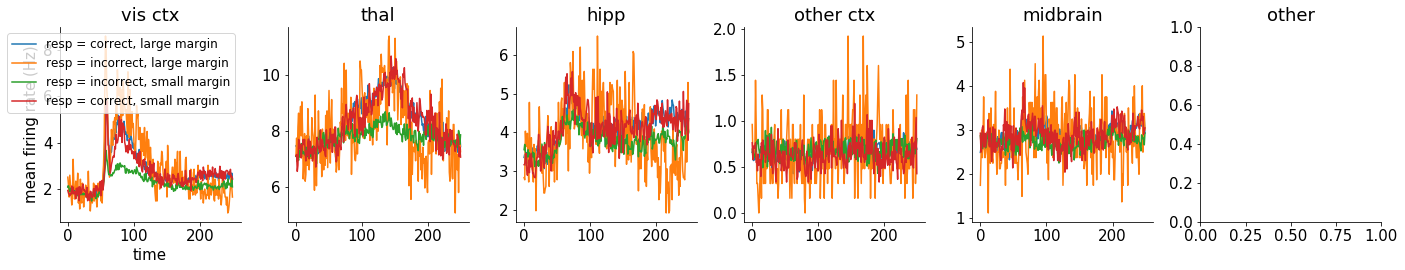

In [5]:
for j in range(len(brain_groups)+1):
    ax = plt.subplot(1,len(brain_groups)+1,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0:
        continue
    plt.plot(1/dt * dat['spks'][barea==j][:,np.logical_and(is_correct, is_large_margin)].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, ~is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(is_correct, ~is_large_margin)].mean(axis=(0,1)))
    #plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
    if j==0:
        plt.legend(['resp = correct, large margin', 'resp = incorrect, large margin', 'resp = incorrect, small margin', 'resp = correct, small margin'], fontsize=12)
        ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')
  #print(np.abs(vis_left-vis_right))



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


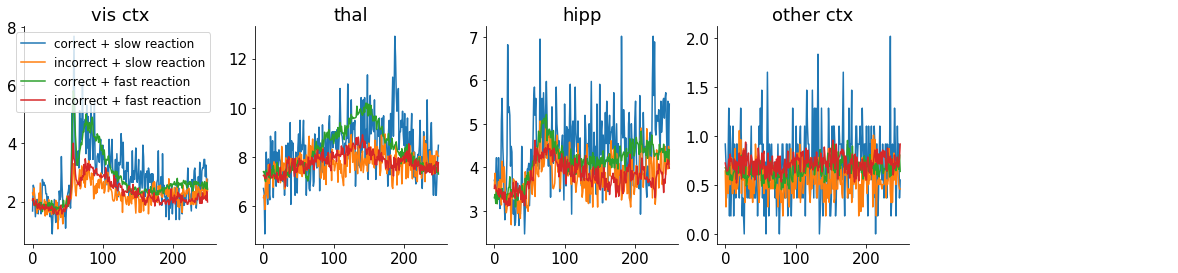

In [6]:
#@title plots by BRAIN REGION and right/wrong, speed
for j in range(4): #len(brain_groups)+1):
    x = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
    plt.title(regions[j])
    b_spikes = dat['spks'][barea==j];
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, ~slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, ~slow_resp)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['correct + slow reaction', 'incorrect + slow reaction', 'correct + fast reaction', 'incorrect + fast reaction'], fontsize=12)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')


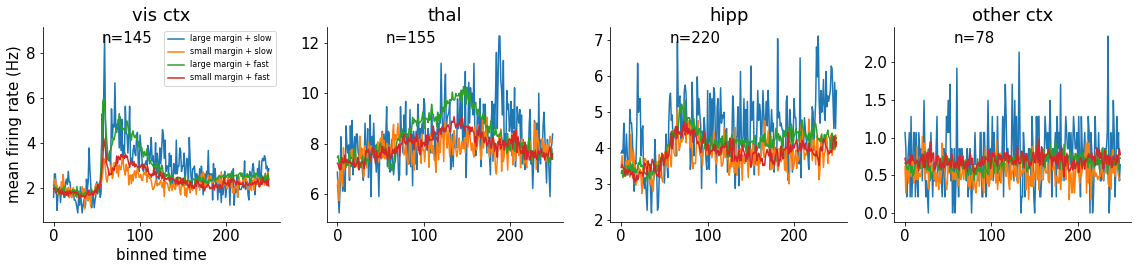

In [7]:
#@title plots by brain region and margin, speed
for j in range(4): #len(brain_groups)+1):
    ax = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
    plt.title(regions[j])
    b_spikes = dat['spks'][barea==j];
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, ~slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, ~slow_resp)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
    if j==0:
        plt.legend(['large margin + slow', 'small margin + slow', 'large margin + fast', 'small margin + fast'], fontsize=8)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')


Now that we've plotted the general differences for each condition/brain region, we need to determine whether we can reduce the dimensionality of the neural responses to produce relevant features. For this, we will use PCA and SparsePCA. These have slightly different interpretations in the neural activity, as you will see. 

[slice(43, 45, None), slice(45, 47, None), slice(47, 49, None), slice(49, 51, None)] slice(99, 101, None)
raw session 3:
raw session 3:  mean


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


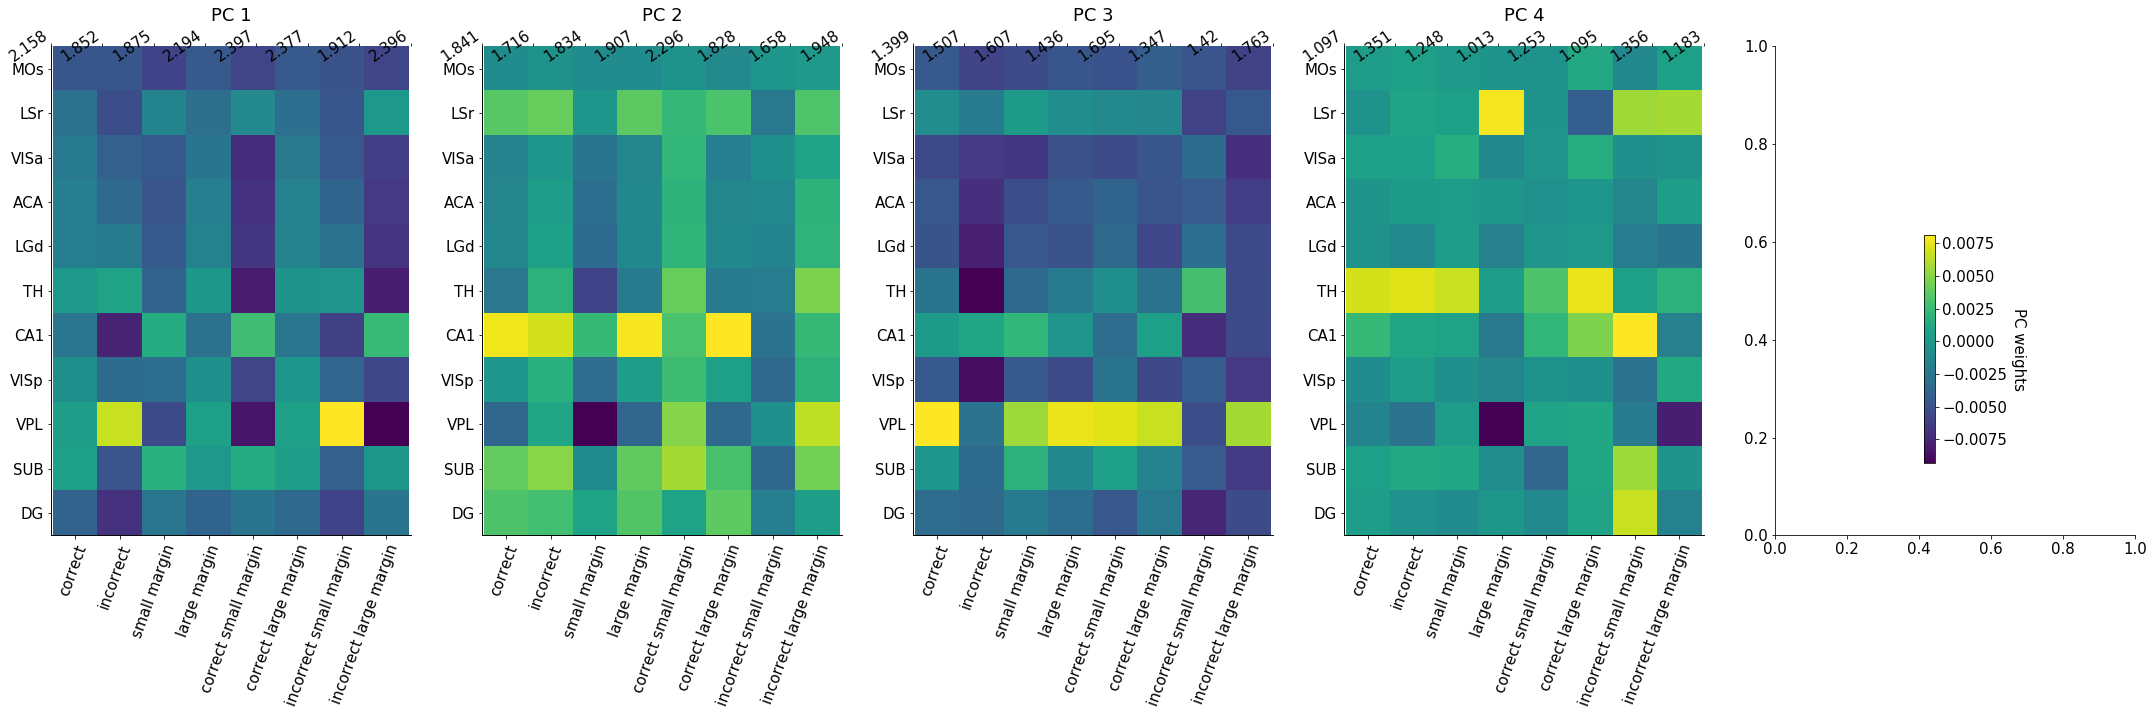

raw session 3:  sum


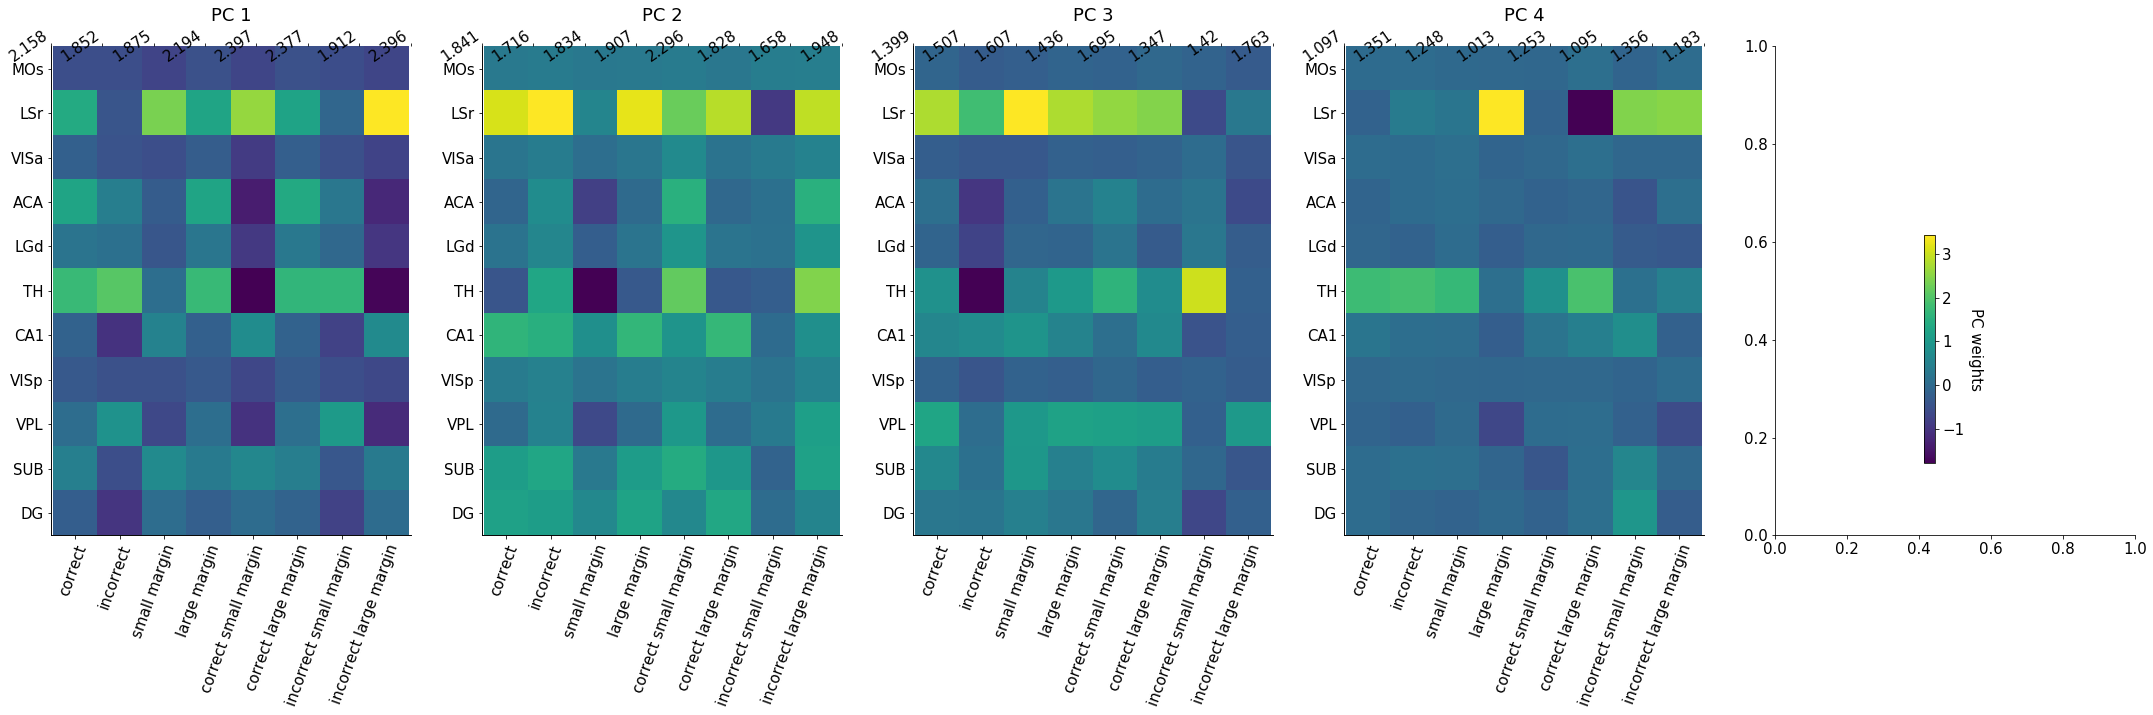

raw session 3:  max


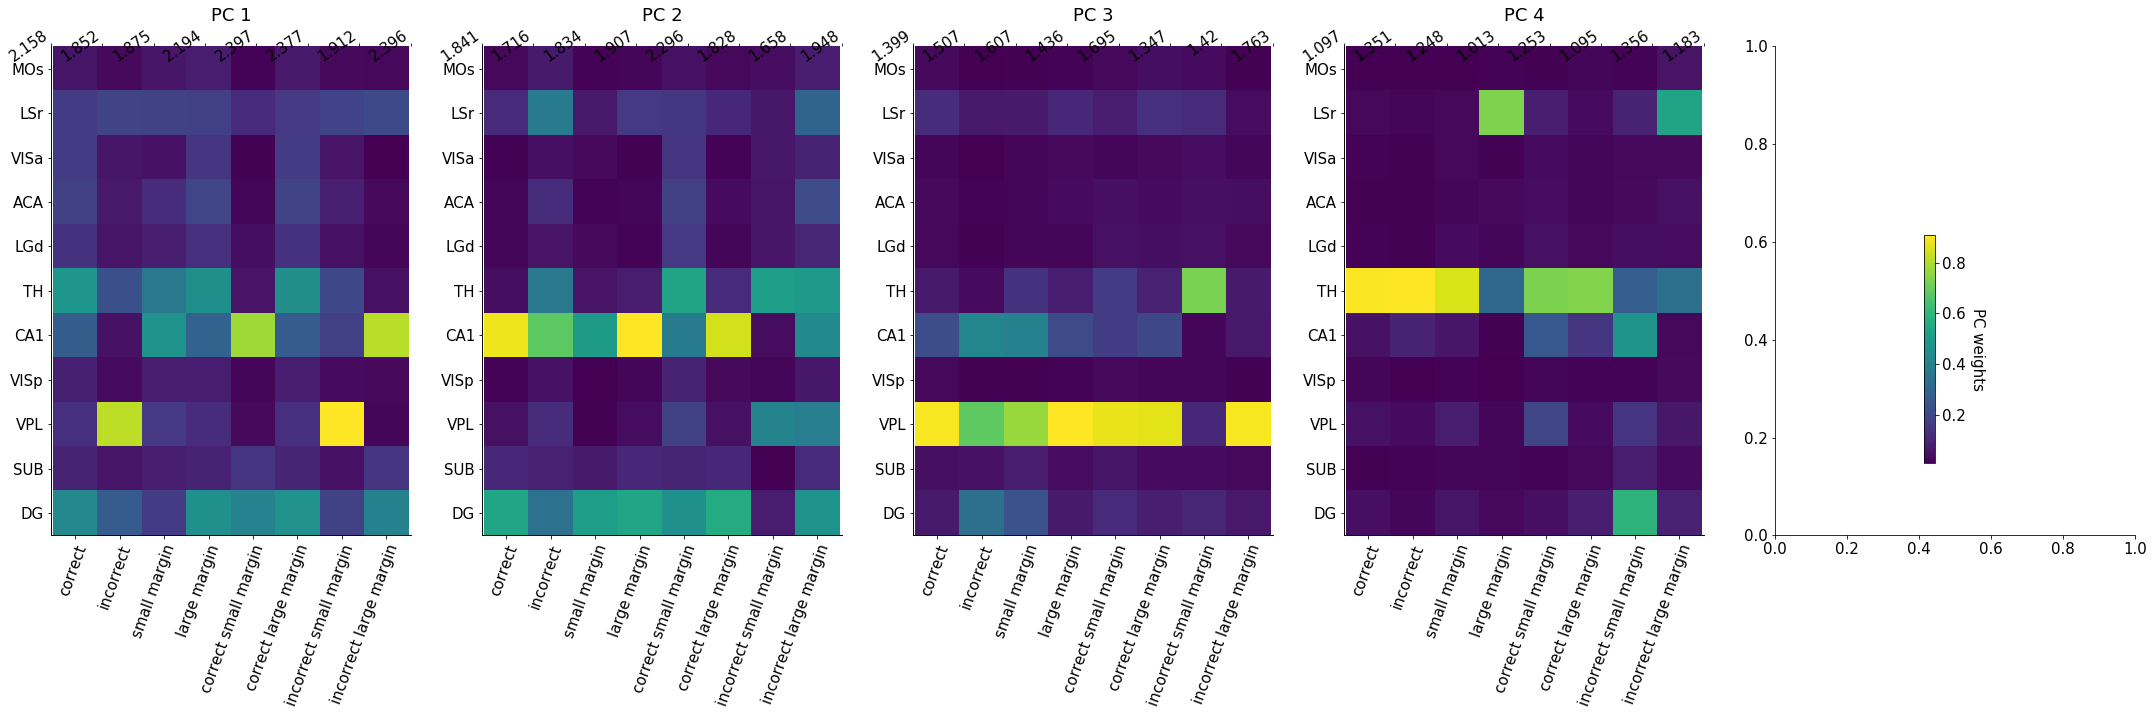

raw session 3:  std


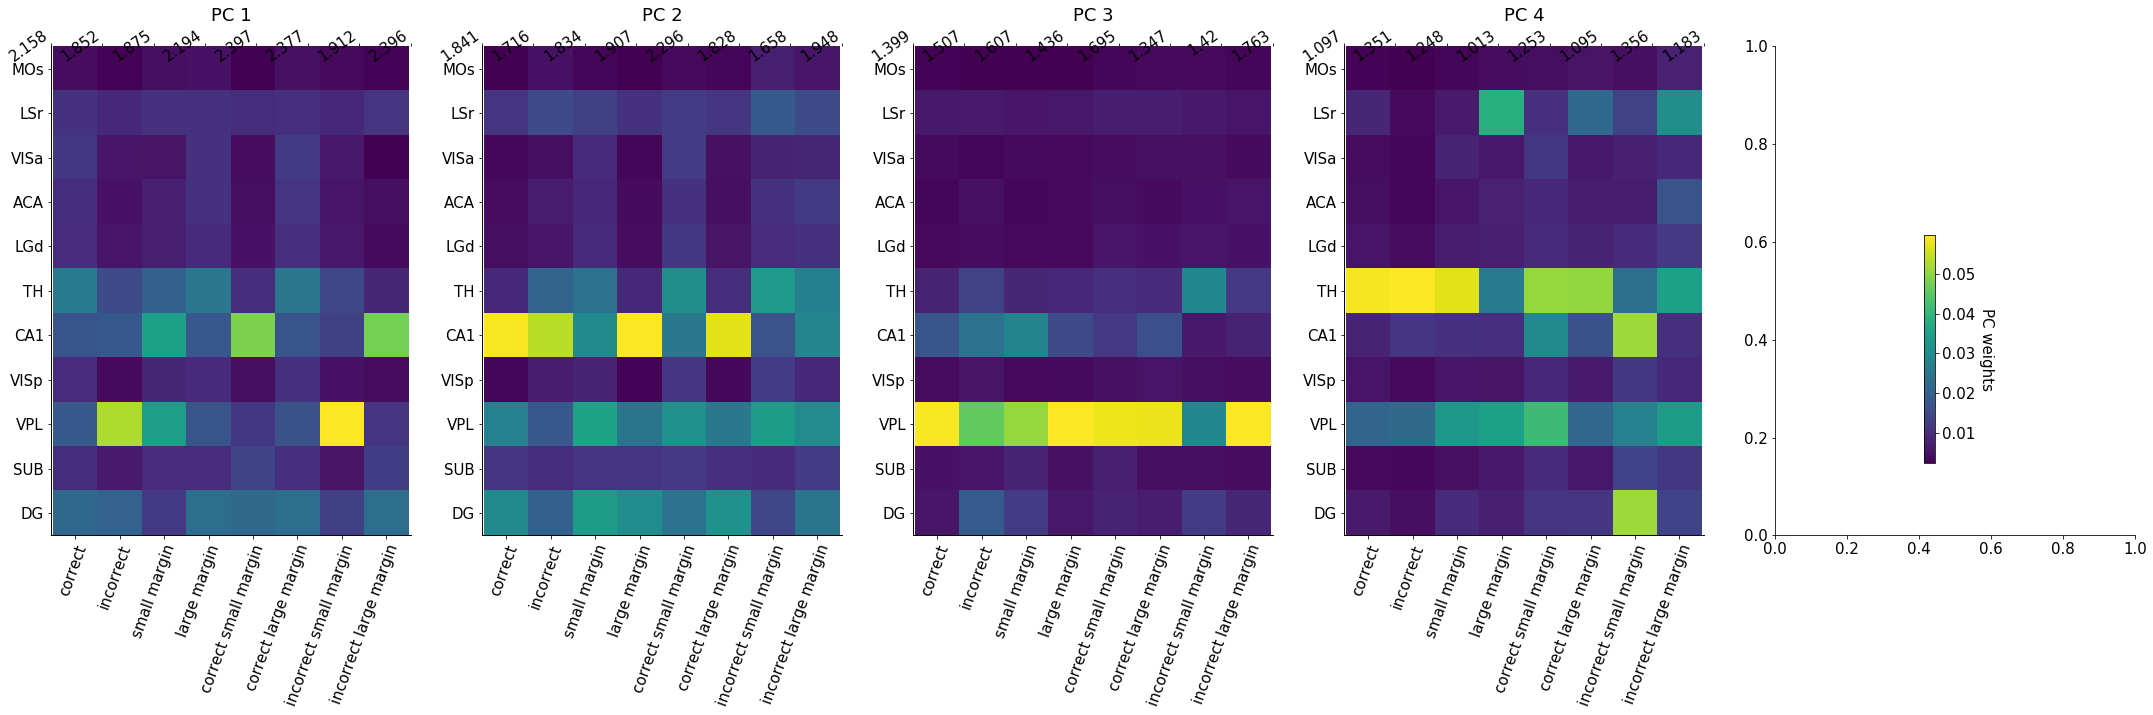

raw session 11:
raw session 11:  mean


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


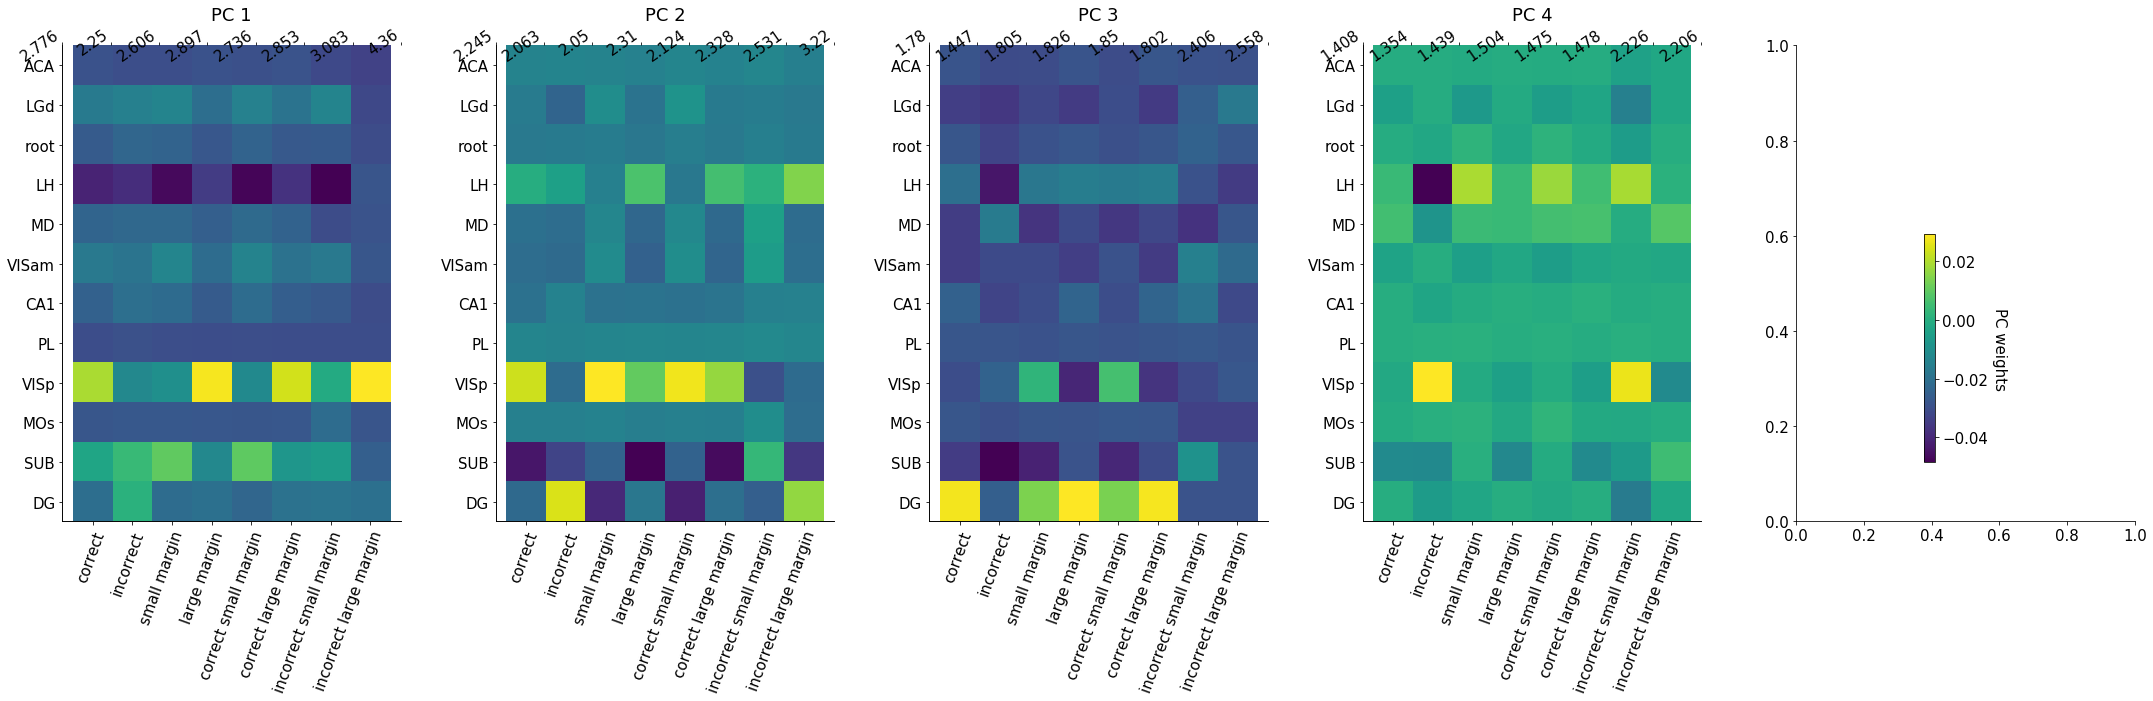

raw session 11:  sum


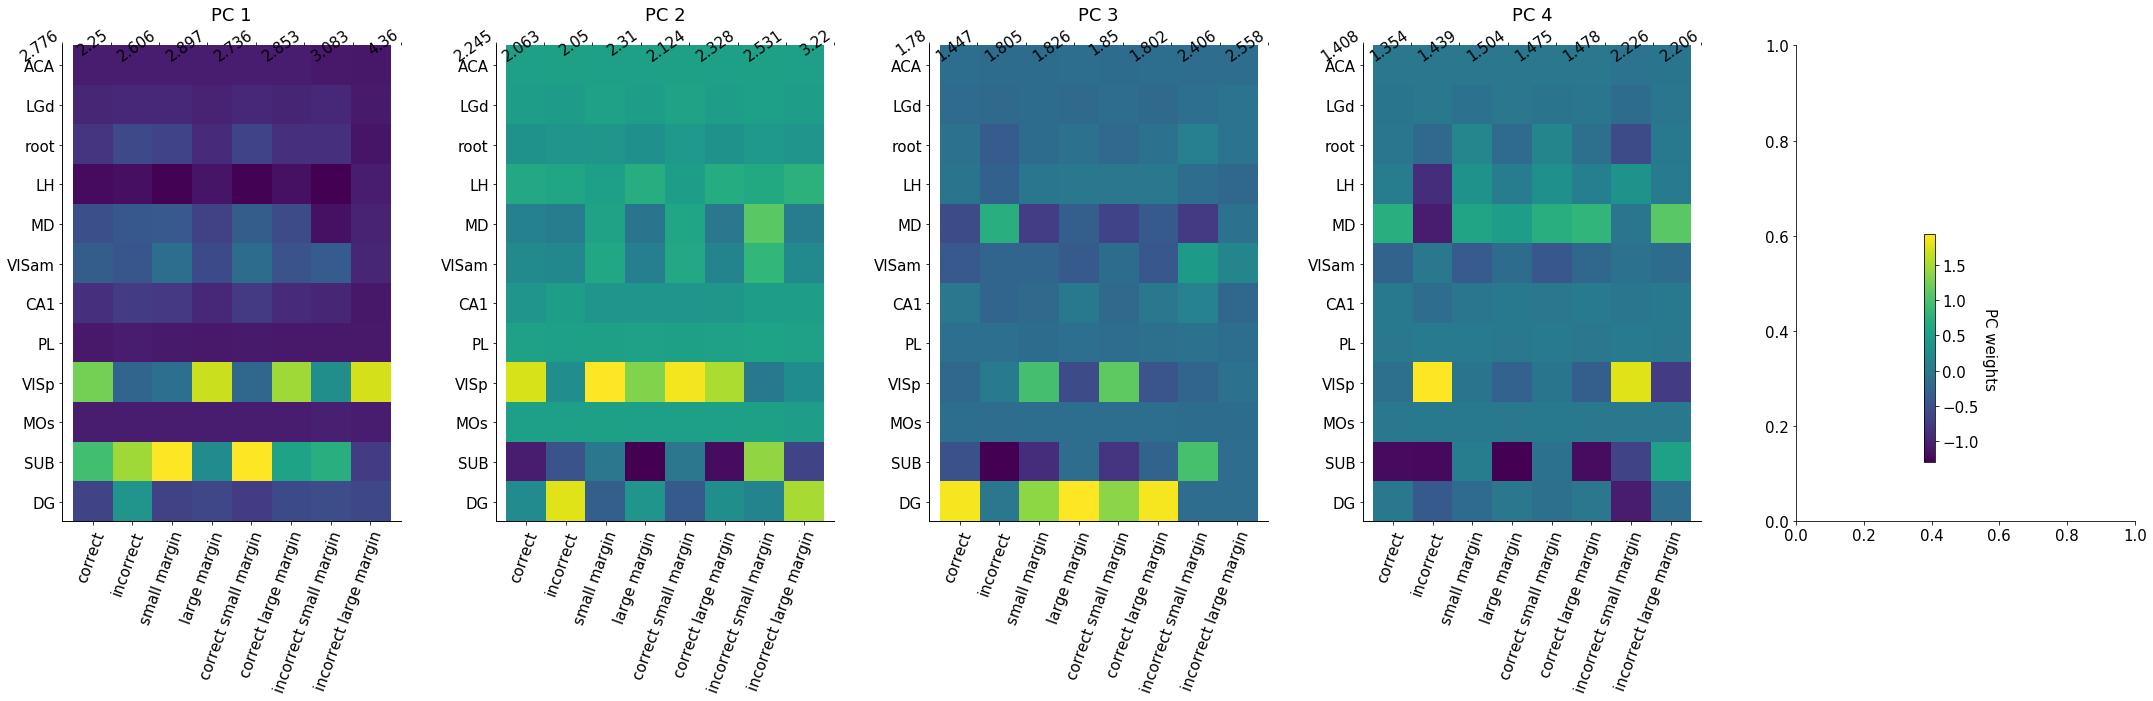

raw session 11:  max


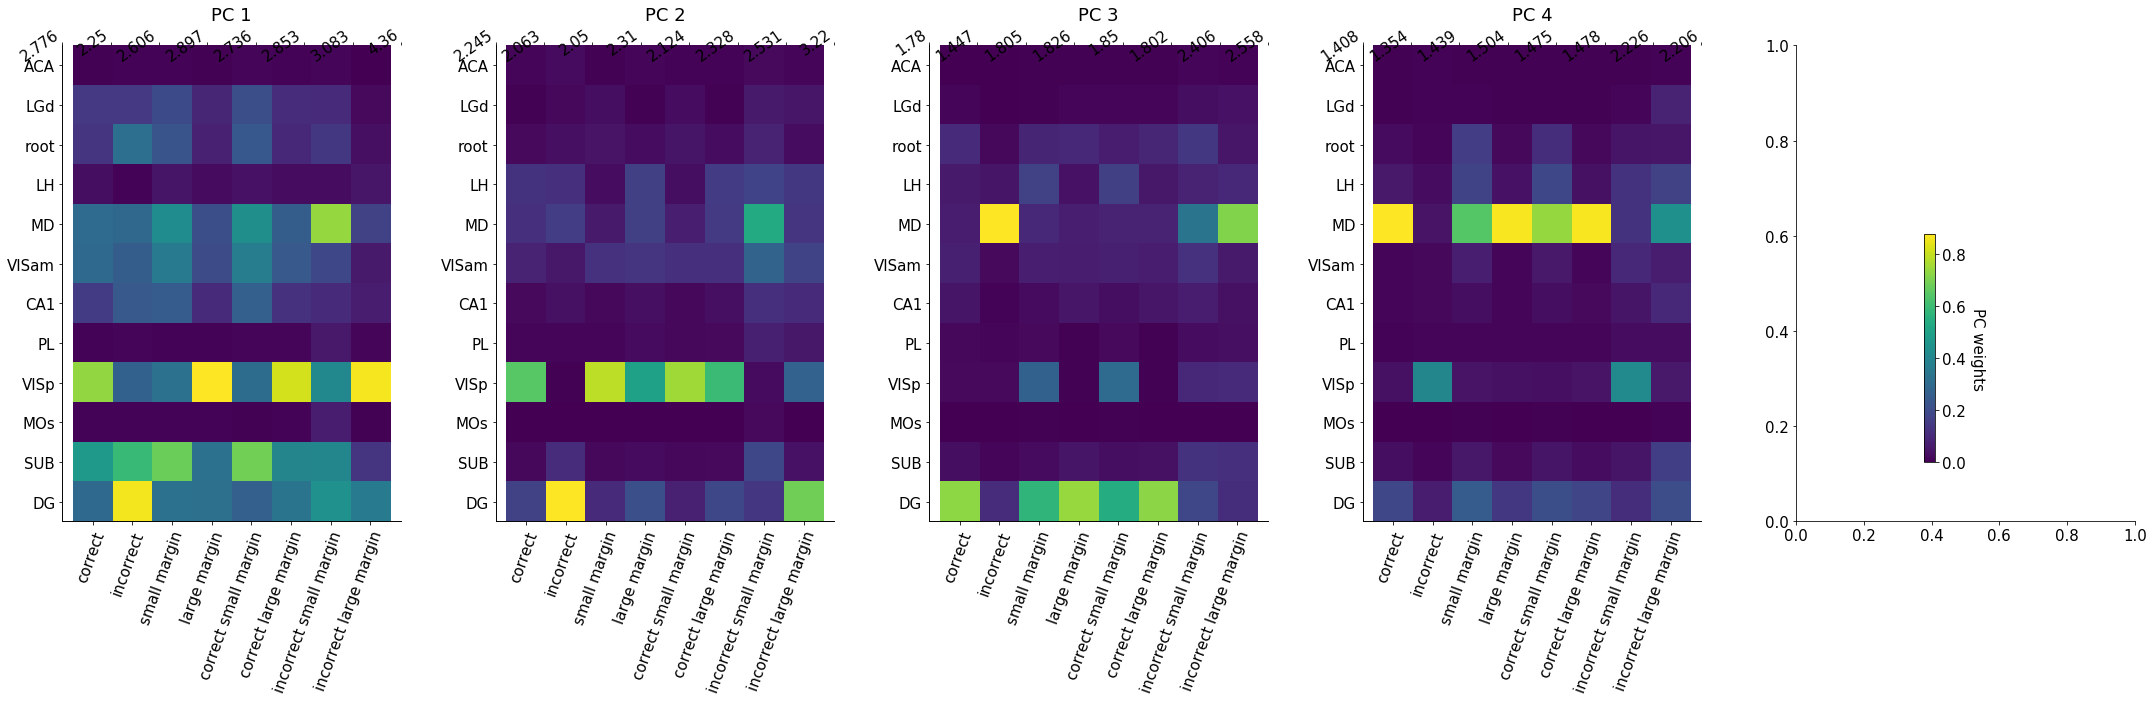

raw session 11:  std


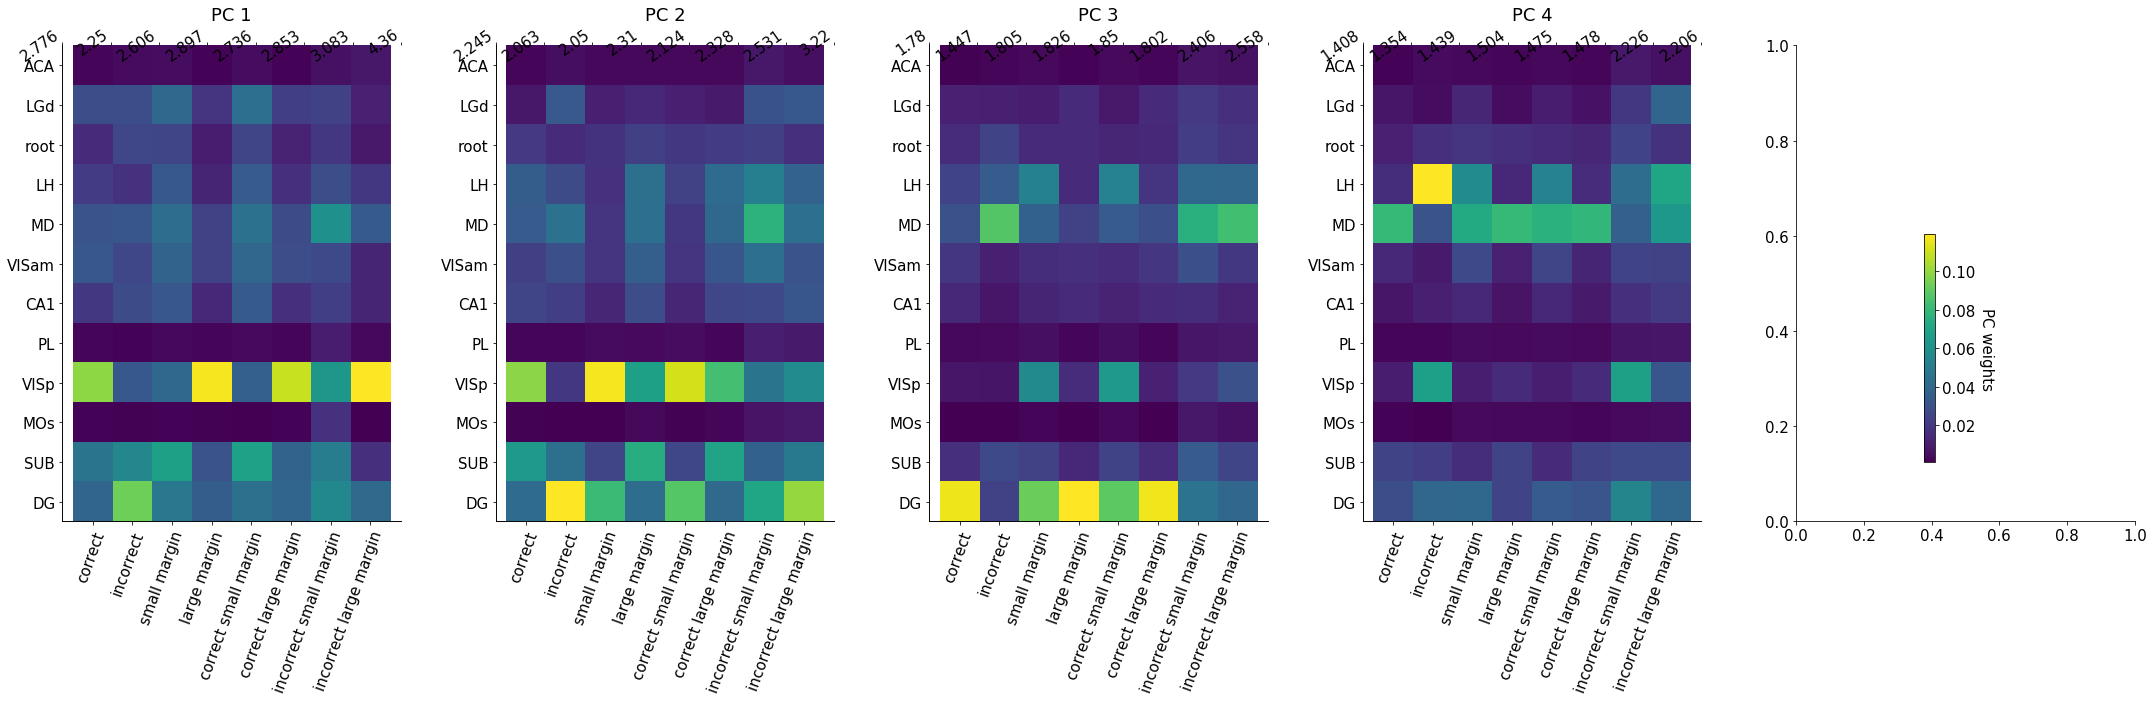

In [8]:
sessions_PCA = [3, 11] # do session 3
methodsStr = ['mean', 'sum', 'max', 'std']
time_seg = listSlices(43, 101, step = 2) # 51 (index 4) is stim onset
(51,70,120)
print(time_seg[0:4], time_seg[-1])
time_seg = [slice(51,75)]
for s in sessions_PCA:
    response = alldat[s]['response'] # right - nogo - left (-1, 0, 1)
    vis_right = alldat[s]['contrast_right'] # 0 - low - high
    vis_left = alldat[s]['contrast_left'] # 0 - low - high
    is_correct = np.logical_and( np.sign(response)==np.sign(vis_left-vis_right),\
                                  response != 0 )
    fil_0025 = WF_filter427(vis_left, vis_right, 0.0, 0.25) # {0,25}
    fil_2550 = WF_filter427(vis_left, vis_right, 0.25, 0.25) # {25,50}
    fil_0050 = WF_filter427(vis_left, vis_right, 0, 0.5) # {0,50}
    fil_50100 = WF_filter427(vis_left, vis_right, 0.5, 0.5) # {50,100}
    cor_0025 = np.logical_and(fil_0025, is_correct)
    cor_2550 = np.logical_and(fil_2550, is_correct)
    cor_0050 = np.logical_and(fil_0050, is_correct)
    cor_50100 = np.logical_and(fil_50100, is_correct)
    incor_0025 = np.logical_and(fil_0025, ~is_correct)
    incor_2550 = np.logical_and(fil_2550, ~is_correct)
    incor_0050 = np.logical_and(fil_0050, ~is_correct)
    incor_50100 = np.logical_and(fil_50100, ~is_correct)

    loMargin = WF_filter427(vis_left,vis_right,0.25,0.25,dir='BI')
    hiMargin = np.logical_or(WF_filter427(vis_left,vis_right,0.50,0.50,dir='BI') \
                               , WF_filter427(vis_left,vis_right,0.25,0.75,dir='BI'))
    clm = np.logical_and(is_correct, loMargin)
    chm = np.logical_and(is_correct, hiMargin)
    iclm = np.logical_and(~is_correct, loMargin)
    ichm = np.logical_and(~is_correct, hiMargin)
    trial_seg = [is_correct, ~is_correct, loMargin, hiMargin, clm, chm, iclm, ichm]
    x_arr = ['correct', 'incorrect' \
             , 'small margin', 'large margin' \
             , 'correct small margin', 'correct large margin' \
             , 'incorrect small margin', 'incorrect large margin']
    print('raw session %0.f:' %s)
    brain_arr, _, PCperSlice_regions, varperSlice = \
        VarHunter427(alldat[s], time_seg = time_seg, trial_seg = trial_seg, trial_seg_isBoolMask = True)
    # make percentage by multiplying it by 100
    varperSlice = varperSlice * 100
    for i in range(len(methodsStr)):
        print('raw session %0.f:' %s, ' %s' %methodsStr[i])
        HeatMapTSegXBrainReg(PCperSlice_regions[methodsStr[i]], brain_arr \
                           , choice_PC = [0,1,2,3], x_arr = x_arr, x2_arr = varperSlice)

In [9]:
#For a more simple presentation, we can look at just the correct vs incorrect distribution in the PC's 
PCA_HeatMap_by_TrailGroup(dat)

NameError: name 'NN' is not defined

In [10]:
#After we've done that, let's look at how PCA and SparsePCA differ in their bases. 
droll = np.reshape(dat['spks'][:,:,51:71], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
W = pd.DataFrame(W).T
W['brain_area'] = dat['brain_area']
print(model.explained_variance_ratio_)


model_sparse = SparsePCA(n_components = 5).fit(droll.T)
W_sparse = model_sparse.components_
pc_10ms_sparse = W_sparse @ np.reshape(dat['spks'], (NN,-1))
pc_10ms_sparse = np.reshape(pc_10ms_sparse, (5, -1, NT))
W_sparse = pd.DataFrame(W_sparse).T
W_sparse['brain_area'] = dat['brain_area']


[0.02624792 0.01963244 0.01870648 0.01377229 0.01241753]


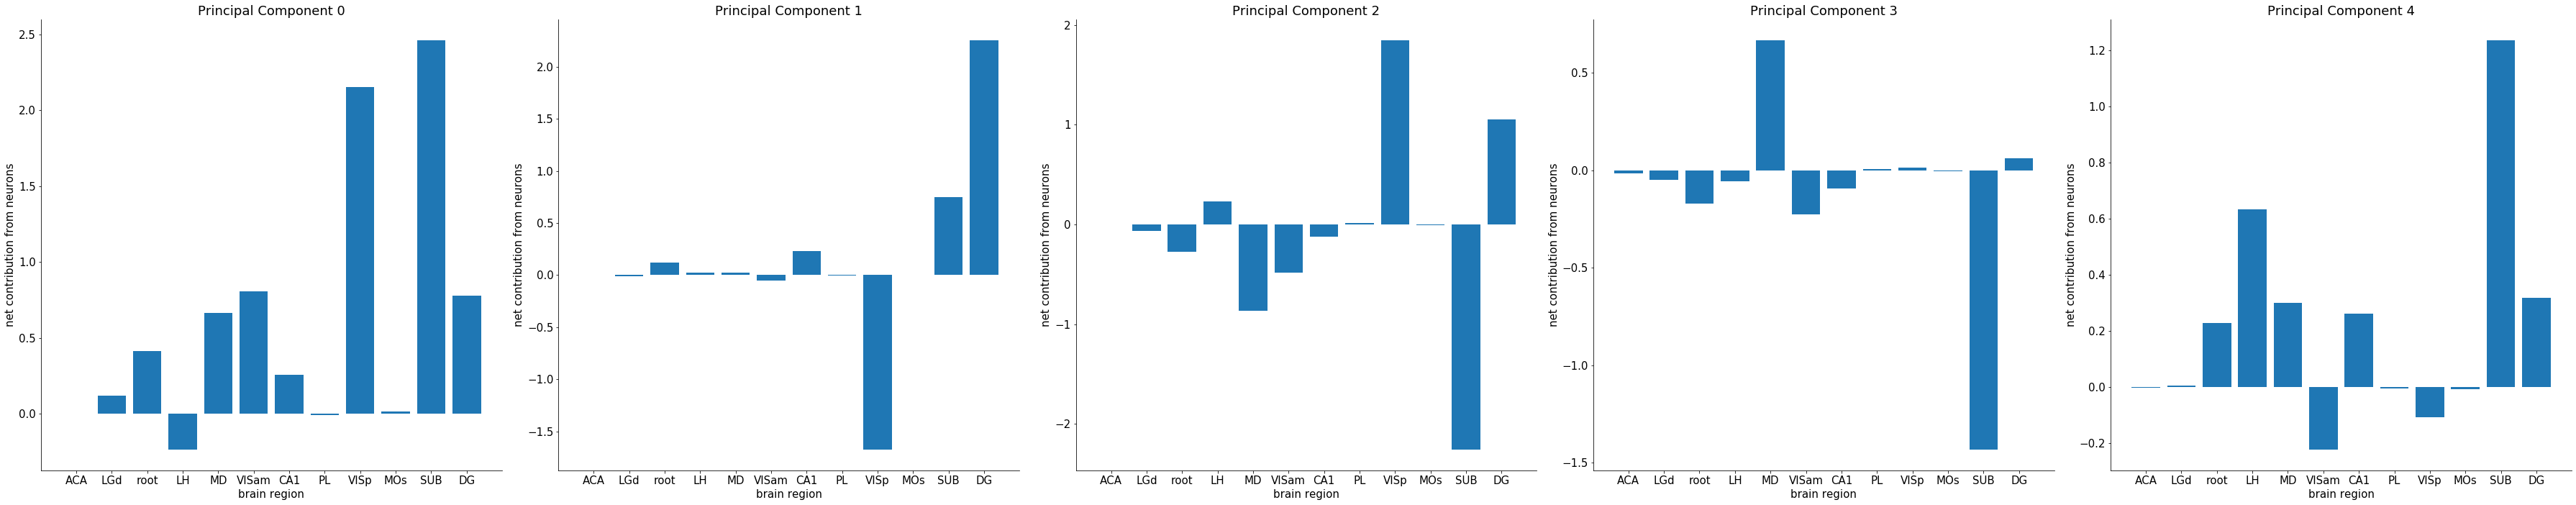

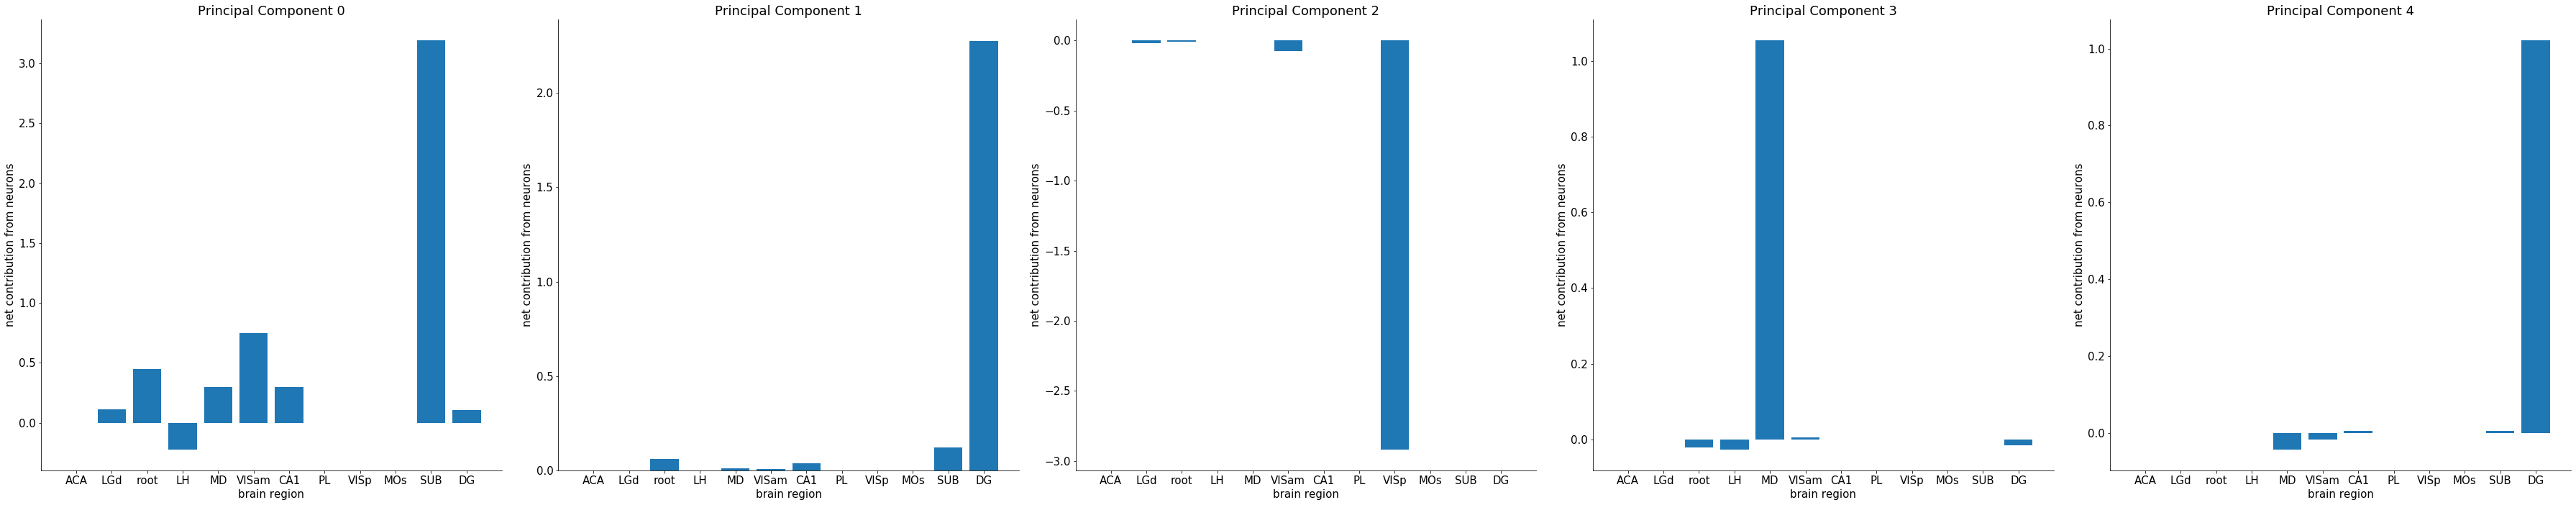

In [11]:
for i,comp in enumerate([W,W_sparse]):
    comp.sort_values(by = ['brain_area'])
    areas = set(comp['brain_area'].to_list())
    #average principal component values by each brain region to see how they contribute
    #but also need to factor out zeros
    W_nozeros = comp.iloc[comp.index[comp.sum(axis = 1) != 0]]
    avg_area_pcs = {}
    for area in areas:
        if area in list(W_nozeros['brain_area']):
            avg_area_pcs[area] = W_nozeros.iloc[np.where(W_nozeros['brain_area'] == area)].sum(axis = 0)[:5]
        else:
            avg_area_pcs[area] = pd.Series([0.0] * 5)
    avg_area_pcs = pd.DataFrame(avg_area_pcs, dtype = float)
    fig, axs = plt.subplots(1,5,figsize = (50,10))
    for row in range(5):
        axs[row].set_title("Principal Component " + str(row))
        axs[row].bar(list(avg_area_pcs.columns),avg_area_pcs.iloc[row])
        axs[row].set_xlabel('brain region')
        axs[row].set_ylabel('net contribution from neurons')


Sparse PCA looks like it finds the best single region that explains variance in each region, whereas PCA finds a contribution of regions. This could potentially be interpreted as regional vs network activity

Text(0.5, 1.0, 'Cluster center distance vs. Time bins')

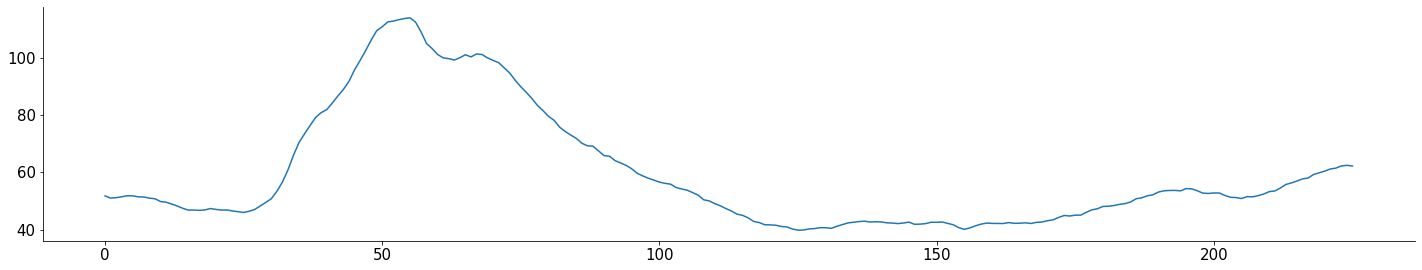

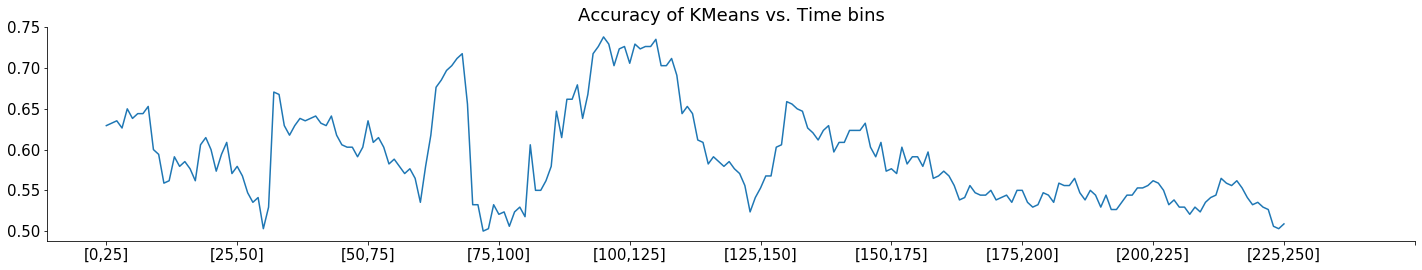

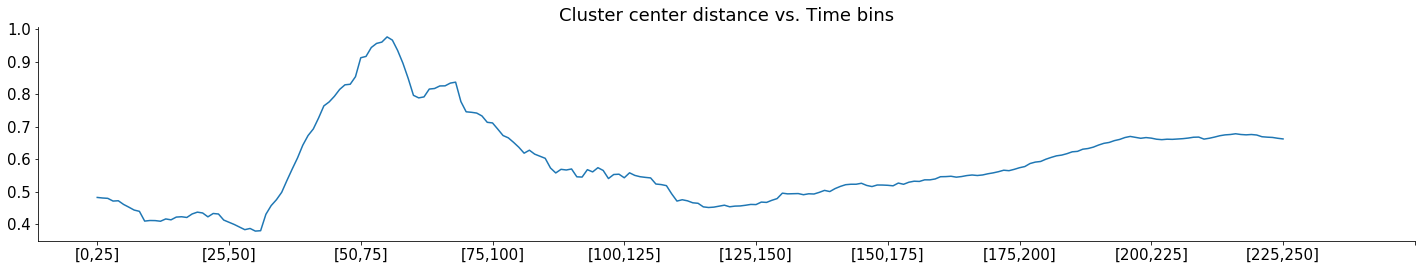

In [12]:
#Clustering Analysis
#TODO: Nizar updates and adds text description?
clust_center_diff = []
distortions = []
acc = []
x = [f'[{x},{x+25}]' for x in range(0,250-24,25)]
for i in range(0,250-24):
    X = pc_10ms[:, :, i:i+25].mean(axis=2).T
    km = KMeans(n_clusters=2).fit(X)
    distortions.append(km.inertia_)
    acc.append(max(np.mean(km.labels_==slow_resp), 1 - np.mean(km.labels_==slow_resp)))
    clust_center_diff.append(np.linalg.norm(km.cluster_centers_[1]-km.cluster_centers_[0]))
fig=plt.figure();plt.plot(distortions)
fig=plt.figure();plt.plot(acc); plt.xticks(np.linspace(0,250,11),labels=x); plt.title("Accuracy of KMeans vs. Time bins")
fig=plt.figure();plt.plot(clust_center_diff); plt.xticks(np.linspace(0,250,11),labels=x); plt.title("Cluster center distance vs. Time bins")

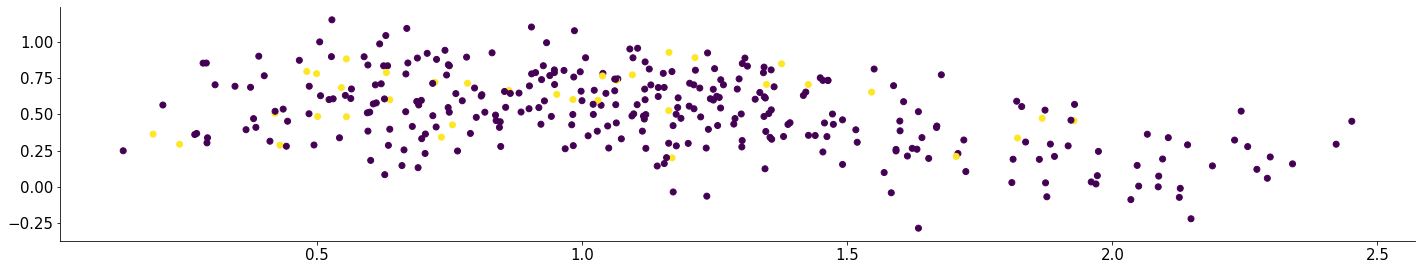

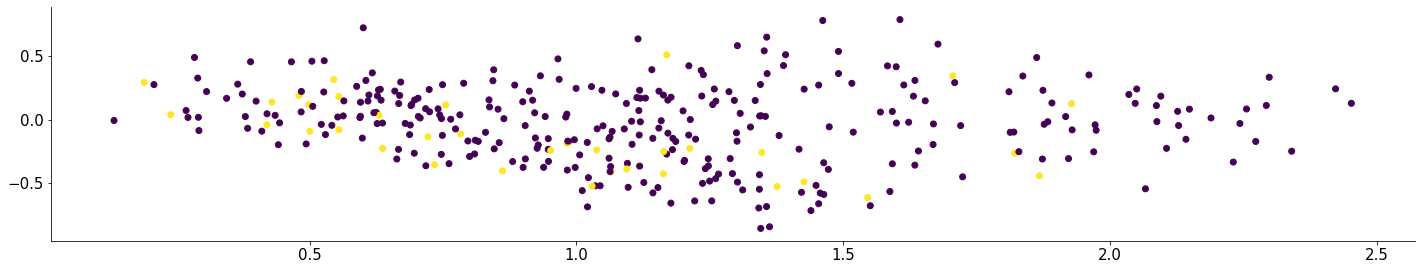

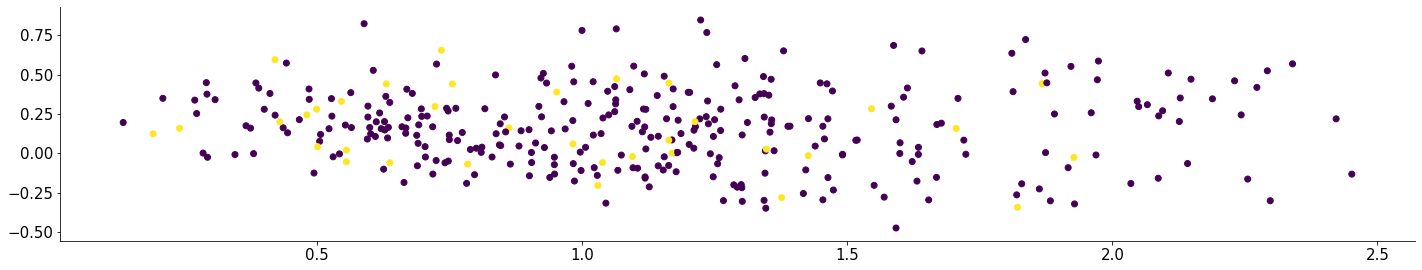

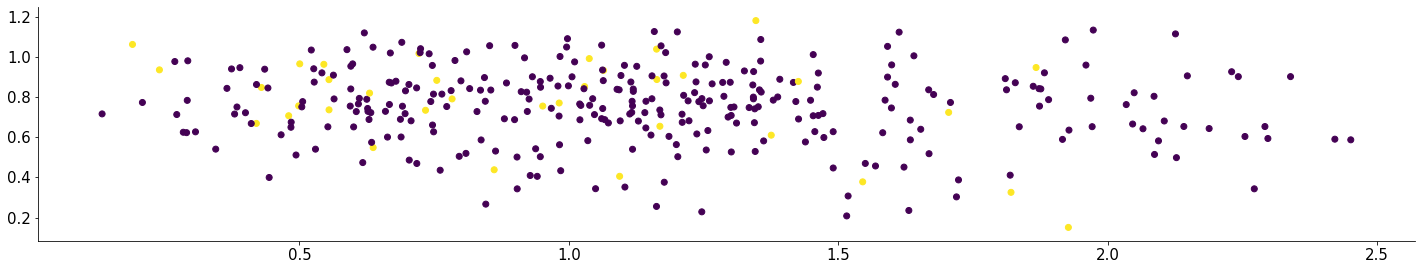

In [13]:
#how do the clusters distribute?
#NIZAR: could you fix this and perhaps make a 3d plot w/ plotly? that would be dope
for i in range(4):
    fig = plt.figure()
    X_1, X_2 = pc_10ms[0][:, 50:75].mean(axis=1), pc_10ms[i+1][:, 50:75].mean(axis=1)
    plt.scatter(X_1, X_2, c=slow_resp)

In [16]:
#Prediction Analysis. Here we utilize Logistic REgression and Decision Trees to explain what features best separate the data

#this function does PCA on single regions (alternatively sparsePCA would do something similar, perhaps)
barea_pcs = VarHunter427(dat, nPC = 5)
print("Cross val of brain region predicting slow vs fast")
for i in range(len(barea_pcs)):
    X, y = np.concatenate(barea_pcs[i],axis=1), slow_resp
    logreg = LogisticRegression(max_iter=2000)
    brain_areas = list(set(dat['brain_area']))
    print(f"Brain region: {brain_areas[i]},", "Crossval score:", f"{np.mean(cross_val_score(logreg, X, y, cv=5)):.3f}")
    
print("Cross val of brain region predicting correct vs incorrect")
for i in range(len(barea_pcs)):
    X, y = np.concatenate(barea_pcs[i],axis=1), is_correct
    logreg = LogisticRegression(max_iter=2000)
    brain_areas = list(set(dat['brain_area']))
    print(f"Brain region: {brain_areas[i]},", "Crossval score:", f"{np.mean(cross_val_score(logreg, X, y, cv=5)):.3f}")

Cross val of brain region predicting slow vs fast


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:

time = pd.DataFrame(dat['response_time'][response != 0])
y = np.array(slow_resp[response != 0],dtype = int)
#if selecting correct vs incorrect, need to subtract 1 so the incorrect class is 1, correct is 0 . 
# #This way upsampling works on class 1, the smaller one
#y = 1 - np.array(is_correct[response != 0], dtype = int)

#if trying to predict whether the stimulus was large vs small
#y = np.array(is_large_margin[response != 0], dtype = int)
#print(dat['response_time'][response !=0])
pc = pc_10ms[:,response!=0,:]
#take the mean individually so that we can use different size windows for each dim
x = np.concatenate([pc[:,:,51:60].mean(axis = 2),pc[:,:,60:70].mean(axis = 2)])
#x = pc[:,:,51:65].mean(axis = 2)
dim = x.shape[0]

#x = np.mean(x, axis = 2)
d = np.vstack([x,y]).T

df = pd.DataFrame(d)
df.columns = [*range(1,x.shape[0]+1),'y']
df_slow = resample(df[df['y'] == 1.0],replace = True, n_samples = np.sum(df['y'] == 0.0),random_state = 1)
df = pd.concat([df_slow,df[df['y'] == 0.0]])


x = np.array([df[i] for i in range(1,dim)]).T
y = np.array([df['y']]).T
#rtmodel = LinearRegression()
#rtmodel = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga', max_iter = 300)
rtmodel = DT(max_depth = 4)
pred = cross_val_predict(rtmodel, x, y)
plt.figure(figsize = (5,5))
plt.scatter(y,pred)
plt.plot(np.arange(0,3,0.5),np.arange(0,3,0.5),color = 'orange')
score = cross_val_score(rtmodel,x,y)
plt.title(score.mean())

print(confusion_matrix(y.squeeze(),pred,labels = [0,1]))
clf = rtmodel.fit(x,y)
plt.figure(figsize = (10,10))
plot_tree(clf)
plt.show()

In [ ]:
#which time points are the most predictive in the relevant region?
#Plotting accuracy of a decision tree over windows
accs = []
windowsize = 5
depth = 4
start, stop = 51, 75 - windowsize
y = np.array(slow_resp[response != 0],dtype = int)
#y = 1 - np.array(is_correct[response != 0], dtype = int)
#y = np.array(is_large_margin[response != 0], dtype = int)

for i in range(start, stop):
    rowaccs = []
    for j in range(i, stop):
        x = np.concatenate([pc[:,:,i:i+windowsize].mean(axis = 2),pc[:,:,j:j+windowsize].mean(axis = 2)])
        dim = x.shape[0]
        #x = np.mean(x, axis = 2)
        d = np.vstack([x,y]).T

        df = pd.DataFrame(d)
        df.columns = [*range(1,x.shape[0]+1),'y']
        df_slow = resample(df[df['y'] == 1.0],replace = True, n_samples = np.sum(df['y'] == 0.0),random_state = 1)
        df = pd.concat([df_slow,df[df['y'] == 0.0]])
        x = np.array([df[i] for i in range(1,dim)]).T
        y_new = np.array([df['y']]).T
        #rtmodel = LinearRegression()
        #rtmodel = LogisticRegression(penalty = 'l1', C = 10, solver = 'saga', max_iter = 300)
        rtmodel = DT(max_depth = depth )
        score = cross_val_score(rtmodel,x,y_new)
        rowaccs.append(score.mean())
    accs.append(rowaccs)

accs = pd.DataFrame(accs)
accs[accs == np.NaN] = 0
plt.plot(np.arange(51,75-windowsize),accs)
plt.title(f"Accuracy of decision tree on PC's to predict large/small margin of depth {depth} on window size of {windowsize}")
plt.xlabel("starting time of window")
plt.ylabel("% accuracy")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=accs.values, x= np.arange(start,stop+1), y = np.arange(start,stop+1))])
fig.show()
